In [1]:
%run ../scripts/by_word.py

Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.
Loading SpaCy...done


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

In [57]:
by_word = []
for idx, row in trial_level_data.loc[:,'condition corrected_text'.split()].iterrows():
    condition = row['condition']
    for token in nlp(row['corrected_text']):
        token = token.text
        by_word.append([condition, token])


In [58]:
by_word_df = pd.DataFrame(by_word, columns=['condition', 'word'])

In [59]:
by_word_df['en_freq'] = by_word_df.word.map(lambda word: wordfreq.word_frequency(word, 'en'))

In [60]:
by_word_df.to_csv('row_per_word.csv', index=False)

In [61]:
by_word_df.to_clipboard()

In [4]:
word_counts_by_condition = count_words_by_condition(trial_level_data)

In [8]:
df = pd.DataFrame([
        dict(condition=condition, word=word, count=count)
        for condition, counter in word_counts_by_condition.items()
        for word, count in counter.most_common()
    ])[['condition', 'word', 'count']]

In [14]:
df['rank_within_condition'] = df.groupby('condition')['count'].rank(ascending=False)

In [65]:
pd.merge(
    by_word_df,
    df,
    on=['word', 'condition', 'en_freq']).to_clipboard(index=False)

In [18]:
import seaborn as sns

In [23]:
sns.set_context('poster')

In [29]:
import wordfreq

In [30]:
df['en_freq'] = df['word'].map(lambda word: wordfreq.word_frequency(word, 'en'))

In [31]:
import scipy.stats

In [38]:
all_words = sorted(set(df['word']))
all_word_freqs = [wordfreq.word_frequency(word, 'en') for word in all_words]
all_word_ranks = pd.Series(all_word_freqs).rank(ascending=False).values#scipy.stats.rankdata(all_word_freqs)

In [39]:
pd.Series(all_word_freqs).rank(ascending=False).values

array([1421. , 1421. , 1421. , ...,   35.5, 1141. , 1168.5])

In [40]:
word_to_enrank = {all_words[idx]: all_word_ranks[idx] for idx in range(len(all_words))}

In [41]:
word_to_enrank['the'], word_to_enrank['drab']

(1.0, 1284.0)

In [42]:
df['en_rank'] = df['word'].map(word_to_enrank)

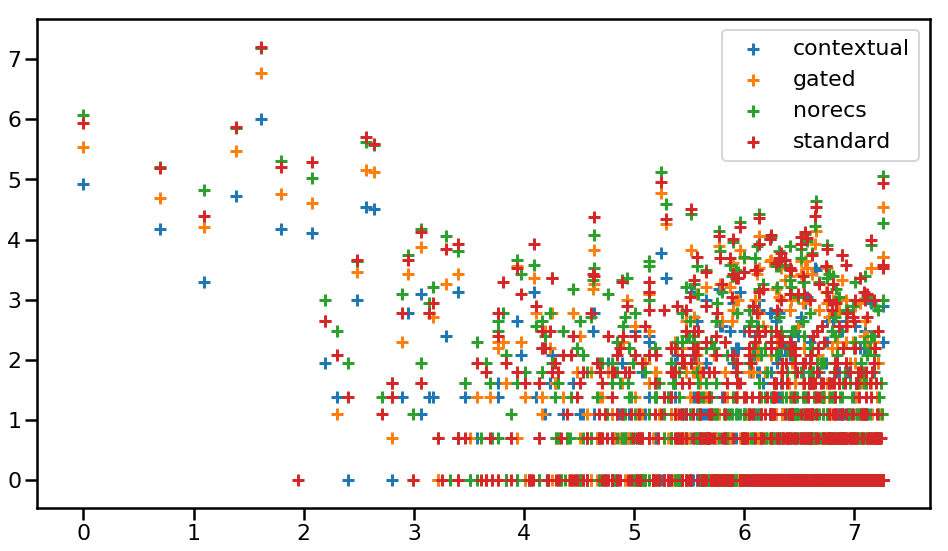

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))
for condition, group in df.groupby('condition'):
#     ax.plot(np.log(group['rank_within_condition']), np.log(group['count']), marker='+', label=condition)
    group = group.sort_values('en_rank')
    ax.scatter(np.log(group['en_rank']), np.log(group['count']), marker='+', label=condition)
# ax.set(xlabel="log rank in English", ylabel="log count")
ax.legend();

In [52]:
df.head()

,condition,word,count,rank_within_condition,en_freq,en_rank,weighted_en_freq
0,standard,a,1335,1.0,0.02290,5.0,30.57150
1,standard,the,378,2.0,0.05890,1.0,22.26420
2,standard,and,355,3.0,0.02570,4.0,9.12350
3,standard,on,301,4.0,0.00832,13.0,2.50432
4,standard,with,267,5.0,0.00708,14.0,1.89036


In [55]:
df['weighted_en_freq'] = df['en_freq'] * df['count']
df.groupby('condition').weighted_en_freq.sum() / df.groupby('condition')['count'].sum()

condition
contextual    0.009404
gated         0.008942
norecs        0.009100
standard      0.009133
dtype: float64

In [56]:
df.en_freq.mean()

0.0006109397248322148

But hm, the rank depends on the total number of words, which scales with the number of participants, and the number of participants is not equal in contextual and gated.

# Classify condition by word

In [88]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

In [70]:
trial_level_data.condition.unique()

array(['standard', 'norecs', 'gated', 'contextual'], dtype=object)

In [71]:
conditions = ['norecs', 'standard', 'gated', 'contextual']
condition2idx = {cond: idx for idx, cond in enumerate(conditions)}

In [125]:
trial_level_data.stimulus.unique()

array(['280480', '236272', '527375', '240275', '71815', '247576',
       '223777', '200451', '227326', '431140', '396295', '275449'],
      dtype=object)

In [126]:
X = []
y = []
for idx, row in trial_level_data.query('stimulus == "280480"').loc[:,'condition stimulus corrected_text'.split()].iterrows():
    X.append(row['corrected_text'])
    y.append(condition2idx[row['condition']])

In [127]:
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=1))

In [128]:
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...     vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1, class_prior=None, fit_prior=True))])

In [129]:
np.argmax(pipeline.named_steps.multinomialnb.coef_, axis=1)

array([  3, 113,   3, 113])

In [130]:
vocab = pipeline.named_steps.tfidfvectorizer.get_feature_names()

In [132]:
probs_by_vocab = pipeline.predict_proba(vocab)

In [133]:
np.argsort(probs_by_vocab, axis=0)[-10:]

array([[143, 136, 141,  28],
       [ 74,  33, 114,   4],
       [106, 172, 152,   6],
       [151,  80, 122,  12],
       [ 34, 178,  44,  63],
       [ 60, 102,  94,  87],
       [173, 132, 165,  20],
       [ 79,  39, 156, 130],
       [107,  98,  16, 129],
       [ 45, 113,  43,  81]])

In [137]:
for stimulus in trial_level_data.stimulus.unique():
    print(stimulus)

    X = []
    y = []
    for idx, row in trial_level_data[trial_level_data.stimulus == stimulus].loc[:,'condition corrected_text'.split()].iterrows():
        X.append(row['corrected_text'])
        y.append(condition2idx[row['condition']])
    pipeline.fit(X, y)
    vocab = pipeline.named_steps.tfidfvectorizer.get_feature_names()
    probs_by_vocab = pipeline.predict_proba(vocab)
    for condition in conditions:
        p = probs_by_vocab[:, condition2idx[condition]]
        
        print(f'{condition}:', ' '.join(vocab[idx] for idx in np.argsort(p)[-10:][::-1]))

    print()

280480
norecs: distance out into while focus chested thin orange headed surroundings
standard: perched multicolored colored standing next yellow is was chest starring
gated: cute below to tricolored looks day right this perches sunny
contextual: it some something blackbird leaves foreground behind at are but

236272
norecs: teammates from as watches right handed number grey dugout left
standard: man is has uniform watching was helmet played finishing catching
gated: of front motion holds other moving strength all gray playing
contextual: hat uniforms an you outlined there can extended also who

527375
norecs: above supplies below shelves shelf organized scanner files corner some
standard: keyboard mouse monitors shown screen cube that as vw working
gated: imac macbook brown long by gray home logo environment most
contextual: workstation shaped things front nice reads death life matter books

240275
norecs: wet board pants suit black surf back shore hair fairly
standard: guy ocean stand

In [140]:
for stimulus in trial_level_data.stimulus.unique():
    print(stimulus)

    X = []
    y = []
    for idx, row in trial_level_data[trial_level_data.stimulus == stimulus].loc[:,'condition corrected_text'.split()].iterrows():
        X.append(row['corrected_text'])
        y.append(condition2idx[row['condition']])
    pipeline.fit(X, y)
    vocab = pipeline.named_steps.tfidfvectorizer.get_feature_names()
    probs_by_vocab = pipeline.predict_proba(vocab)
    for condition in conditions:
        p = probs_by_vocab[:, condition2idx[condition]]
        words = []
        for idx in np.argsort(p)[::-1]:
            if p[idx] > .5:
                words.append(vocab[idx])
        
        print(f"{condition}:", ' '.join(words))

    print()

280480
norecs: 
standard: perched multicolored
gated: 
contextual: 

236272
norecs: 
standard: man is
gated: 
contextual: 

527375
norecs: above supplies
standard: keyboard mouse monitors shown
gated: 
contextual: 

240275
norecs: wet
standard: guy
gated: 
contextual: 

71815
norecs: there
standard: approaching
gated: 
contextual: 

247576
norecs: white
standard: european
gated: 
contextual: 

223777
norecs: outdoor
standard: traveling down near
gated: 
contextual: 

200451
norecs: enjoying kids at
standard: five standing adults together dad three
gated: 
contextual: 

227326
norecs: an
standard: together newlyweds
gated: 
contextual: 

431140
norecs: unopened
standard: tank
gated: 
contextual: 

396295
norecs: to
standard: containing
gated: 
contextual: 

275449
norecs: foreground
standard: colored owner
gated: 
contextual: 



In [139]:
pipeline.predict_proba(['colored'])

array([[0.16849801, 0.52741754, 0.23386875, 0.07021571]])

In [141]:
from textrec.automated_analyses import taps_to_type

In [145]:
trial_level_data.loc[:,'condition corrected_text stimulus'.split()].iloc[0]

condition                                                  standard
corrected_text    a black, white and tan colored bird perches on...
stimulus                                                     280480
Name: 0, dtype: object

In [151]:
from IPython.display import HTML

In [156]:
chunks = []
for tap in taps_to_type(trial_level_data.stimulus.iloc[0], trial_level_data.corrected_text.iloc[0].replace('.', '').replace(',', '')):
    if tap['type'] == 'key':
        chunks.append(('key', tap['key']))
    elif tap['type'] == 'rec':
        typ = 'full' if len(tap['cur_word']) == 0 else 'part'
        chunks.append((typ, tap['word'][len(tap['cur_word']):]))
    else:
        assert False

res = ''
for typ, chars in chunks:
    if typ == 'full':
        res += f'<font color=red>{chars}</font> '
    elif typ == 'part':
        res += f'<font color=blue>{chars}</font> '
    else:
        res += chars
HTML(res)

In [177]:
def taps_to_html(taps):
    def b(text):
        return f'<b>{text}</b>'
    def clr(color, text):
        return f'<font color="{color}">{text}</font>'
    res = ''
    for tap in taps:
        if tap['type'] == 'key':
            res += tap["key"]
        elif tap['type'] == 'rec':
            chars = tap['word'][len(tap['cur_word']):]
            if len(tap['cur_word']) == 0:
                res += clr('red', chars)
            else:
                res += chars
            res += ' '
        else:
            assert False
    return res

HTML(taps_to_html(
    taps_to_type(
#         trial_level_data.stimulus.iloc[0],
        None,
        trial_level_data.corrected_text.iloc[0].replace('.', '').replace(',', ''))))

In [180]:
taps = []
for _, row in trial_level_data.sort_values('stimulus').iloc[:20].loc[:, 'stimulus corrected_text'.split()].iterrows():
    stimulus = int(row['stimulus'])
    text = row['corrected_text'].replace('.', '').replace(',', '')
    taps.append((
        taps_to_type(stimulus, text),
        taps_to_type(None, text)))

In [181]:
tap_htmls = [
    [taps_to_html(t) for t in row]
    for row in taps
]

In [182]:
HTML('<table style="width: 10000px;">{}</table>'.format(
    ''.join(
        '<tr>{}</tr>'.format(
            ''.join('<td>{}</td>'.format(col)
                    for col in row))
        for row in np.array(tap_htmls).T)))

people are flying kites while standing on the beach together,people flying kites in the air on the beach,a few kids and parents flying kites at a park beach,three people on a beach flying kites,a group of people flying colorful kites on a beach,a tall man in a red collar shirt and khakis flying a colorful butterfly kite with two young girls,the father was holding the colorful kites for his kids at the beach while they flew some of the others,multiple people on a beach flying colorful kites,people are flying kites,dozens of kites are soaring in the sky,a group of people flying kites at the beach,a man in a red shirt and beige khakis flying kites with others at the beach,a family is preparing to fly a colorful butterfly kite with multiple kites in the air in the distance,a family of three flying kites on a beach on a sunny day,a person flying kites in the sky near some trees,a man is preparing to fly a butterfly kite while other kites are flying in the background,a day by the water with two kids and a man trying to fly kites with other kites being up in the background already,people flying brightly colored kites with long tails on a sunny beach,a father and his children are flying their kites at the beach,various multicolored kites soar through a clear and sunny sky led by the children and adults below
people are flying kites while standing on the beach together,people flying kites in the air on the beach,a few kids and parents flying kites at a park beach,three people on a beach flying kites,a group of people flying colorful kites on a beach,a tall man in a red collar shirt and khakis flying a colorful butterfly kite with two young girls,the father was holding the colorful kites for his kids at the beach while they flew some of the others,multiple people on a beach flying colorful kites,people are flying kites,dozens of kites are soaring in the sky,a group of people flying kites at the beach,a man in a red shirt and beige khakis flying kites with others at the beach,a family is preparing to fly a colorful butterfly kite with multiple kites in the air in the distance,a family of three flying kites on a beach on a sunny day,a person flying kites in the sky near some trees,a man is preparing to fly a butterfly kite while other kites are flying in the background,a day by the water with two kids and a man trying to fly kites with other kites being up in the background already,people flying brightly colored kites with long tails on a sunny beach,a father and his children are flying their kites at the beach,various multicolored kites soar through a clear and sunny sky led by the children and adults below


In [172]:
HTML("<table>" + '\n'.join(
    "<tr><td>{}</td><td>{}</td></tr>".format(taps_to_html(a), taps_to_html(b)) for a, b in taps
    ) + '</table>')

a black white and tan colored bird perches on a branch and looks to its left,a black white and tan colored bird perches on a branch and looks to its left
a baseball player wearing a black shirt and grey pants swings at a baseball pitch with his bat,a baseball player wearing a black shirt and grey pants swings at a baseball pitch with his bat
a brown computer desk and shelf containing a pc laptop and many desk items,a brown computer desk and shelf containing a pc laptop and many desk items
a surfer rides a wave while wearing a white shirt and black pants,a surfer rides a wave while wearing a white shirt and black pants
a professional tennis player runs to backhand a tennis serve,a professional tennis player runs to backhand a tennis serve
a city street with tall buildings people and a very tall red bus,a city street with tall buildings people and a very tall red bus
a brown train at a train station with white and blue walls,a brown train at a train station with white and blue walls
people enjoying the beach and flying kites,people enjoying the beach and flying kites
a newly wed couple cutting the wedding cake in black and white,a newly wed couple cutting the wedding cake in black and white
a bathroom featuring a white sink and toilet,a bathroom featuring a white sink and toilet
a bathroom with a white toilet and glass shower door with a brown towel hanging from it,a bathroom with a white toilet and glass shower door with a brown towel hanging from it


In [184]:
def get_full_word_recs(taps):
    return [tap['word'] for tap in taps if tap['type'] == 'rec' and tap['cur_word'] == '']
get_full_word_recs(taps[0][1])

['are', 'kites', 'standing', 'on', 'the', 'beach', 'together']

In [208]:
taps_by_stimulus = {}
for stimulus, data in trial_level_data.groupby('stimulus'):
    taps_by_stimulus[stimulus] = taps = []
    for _, row in data.sort_values('stimulus').loc[:, 'stimulus corrected_text'.split()].iterrows():
        stimulus = int(row['stimulus'])
        text = row['corrected_text'].replace('.', '').replace(',', '')
        taps.append((
            taps_to_type(stimulus, text),
            taps_to_type(None, text)))
        

In [209]:
contextual_fwrecs = [
    word
    for taps, _ in taps_by_stimulus['200451']
    for word in get_full_word_recs(taps)]

In [210]:
Counter(contextual_fwrecs).most_common(10)

[('a', 205),
 ('kites', 151),
 ('the', 115),
 ('beach', 101),
 ('flying', 98),
 ('on', 64),
 ('people', 59),
 ('in', 40),
 ('are', 39),
 ('and', 34)]

In [211]:
standard_fwrecs = [
    word
    for _, taps in taps_by_stimulus['200451']
    for word in get_full_word_recs(taps)]

In [212]:
Counter(standard_fwrecs).most_common(10)

[('a', 203),
 ('kites', 120),
 ('the', 115),
 ('beach', 95),
 ('on', 65),
 ('in', 49),
 ('are', 38),
 ('flying', 33),
 ('man', 33),
 ('people', 32)]

In [213]:
pipeline.fit([' '.join(standard_fwrecs), ' '.join(contextual_fwrecs)], [0, 1])

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...     vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1, class_prior=None, fit_prior=True))])

In [214]:
vocab = sorted(set(contextual_fwrecs + standard_fwrecs))
np.argsort(pipeline.predict_proba(vocab), axis=0)

array([[29, 47],
       [61, 36],
       [28, 39],
       [35, 79],
       [ 6, 87],
       [82, 51],
       [43, 92],
       [67, 80],
       [41, 13],
       [64, 19],
       [66, 16],
       [ 4, 83],
       [54, 85],
       [42,  7],
       [45, 84],
       [73, 72],
       [26, 40],
       [48, 74],
       [46, 50],
       [23, 24],
       [ 9, 18],
       [76, 58],
       [52, 20],
       [21, 68],
       [12, 90],
       [ 8,  2],
       [62, 10],
       [14, 60],
       [56,  1],
       [78, 63],
       [22, 59],
       [27, 91],
       [ 5, 65],
       [49, 44],
       [81, 53],
       [ 0, 70],
       [11,  3],
       [86, 38],
       [71, 37],
       [69, 88],
       [89, 15],
       [15, 25],
       [65, 77],
       [17, 75],
       [59, 55],
       [57, 17],
       [70, 57],
       [55, 31],
       [53, 32],
       [75, 33],
       [88, 34],
       [77, 30],
       [ 3, 69],
       [25, 89],
       [91, 86],
       [30, 71],
       [44, 11],
       [31,  0],
       [32, 81

In [216]:
vocab[47], vocab[29]

('man', 'flying')

In [221]:
data = trial_level_data[trial_level_data.stimulus == '200451']
data.corrected_text.str.contains('flying').groupby(data.condition).mean()

condition
contextual    0.777778
gated         0.648649
norecs        0.648148
standard      0.660714
Name: corrected_text, dtype: float64

# Plot excess usage against excess-recommendations

# Is there a difference in POS types?

In [222]:
from textrec import automated_analyses

In [225]:
pos_counts = [automated_analyses.pos_counts(text) for text in trial_level_data.corrected_text]

In [230]:
pos_counts = pd.DataFrame(pos_counts).fillna(0).astype(float)

In [240]:
normed_pos_counts = pos_counts.div(pos_counts.sum(axis=1), axis=0)

In [243]:
normed_pos_counts.groupby(trial_level_data.condition).mean()

,ADJ,ADP,ADV,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SYM,VERB
condition,,,,,,,,,,,,,
contextual,0.105838,0.148537,0.007699,0.034441,0.203349,0.338684,0.005106,0.009082,0.010012,0.000000,0.019393,0.000000,0.117858
gated,0.123413,0.129858,0.011986,0.037900,0.197745,0.333690,0.004873,0.009861,0.007402,0.000046,0.023528,0.000161,0.119536
norecs,0.118021,0.137655,0.014914,0.034420,0.198183,0.334096,0.006379,0.009499,0.006281,0.000000,0.021480,0.000000,0.119073
standard,0.104544,0.137841,0.014291,0.036703,0.201375,0.336217,0.006678,0.008875,0.006140,0.000087,0.019260,0.000197,0.127792


In [244]:
normed_pos_counts.to_clipboard(index=False)

In [252]:
normed_pos_counts.set_index(trial_level_data.condition).unstack().to_frame('frac').to_clipboard()

In [260]:
progressive_tense = 0 + trial_level_data.corrected_text.str.contains(r'(?:is|are) \w+ing')
pd.concat([
    trial_level_data,
    normed_pos_counts,
    progressive_tense.to_frame('progressive_tense')], axis=1).to_csv('with_pos_fracs.csv')

In [256]:
!open .

In [259]:
trial_level_data.corrected_text.str.contains(r'(?:is|are) \w+ing').groupby(trial_level_data.condition).mean()

condition
contextual    0.197917
gated         0.153153
norecs        0.161950
standard      0.215409
Name: corrected_text, dtype: float64

In [262]:
trial_level_data.corrected_text.str.findall(r'(?:is|are) \w+ing')

0                     []
1                     []
2                     []
3                     []
4                     []
5                     []
6                     []
7                     []
8                     []
9                     []
10                    []
11                    []
12                    []
13                    []
14                    []
15                    []
16                    []
17                    []
18                    []
19                    []
20                    []
21                    []
22                    []
23                    []
24                    []
25                    []
26                    []
27           [is riding]
28                    []
29      [is approaching]
              ...       
1878                  []
1879                  []
1880                  []
1881      [is crouching]
1882        [is hanging]
1883                  []
1884        [is guiding]
1885        [are flying]
1886                  []
